In [1]:
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import utilities
import cv2
import os
import matplotlib.pyplot as plt

In [6]:
def show_image(img, figsize=(10,10), gray=True):
    plt.figure(figsize=figsize)
    plt.imshow(img, 'gray' if gray else None)
    plt.axis('off')

In [2]:
class CustomDataset(Dataset):
  def __init__(self, data: np.ndarray, feature_extractor):
    super(CustomDataset, self).__init__()

    
    self.data = data
    self.feature_extractor = feature_extractor

  def __len__(self):
    return len(self.data)
  

  def __getitem__(self, idx):
    image = self.data[idx][:, :256, :][:, :, [2, 1, 0]]
    mask = self.data[idx][:, 256:, :][:, :, [2, 1, 0]]
    mask = utilities.encoded_mask(mask)

    encoded_input = self.feature_extractor(image, mask, return_tensors="pt")
    for k, v in encoded_input.items():
      encoded_input[k].squeeze_()

    return encoded_input

In [4]:
p_image = r"D:\segformer\Unstained"
images = os.listdir(p_image)
images

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\segformer\\Unstained'

In [5]:
p_mask = r"D:\segformer\Masks"
masks = os.listdir(p_mask)
masks

['HC23-00605-A1-1.[0x0].png',
 'HC23-00605-A1-1.[0x2048].png',
 'HC23-00605-A1-1.[0x3072].png',
 'HC23-00605-A1-1.[10240x0].png',
 'HC23-00605-A1-1.[10240x1024].png',
 'HC23-00605-A1-1.[10240x2048].png',
 'HC23-00605-A1-1.[10240x3072].png',
 'HC23-00605-A1-1.[1024x1024].png',
 'HC23-00605-A1-1.[1024x2048].png',
 'HC23-00605-A1-1.[11264x1024].png',
 'HC23-00605-A1-1.[11264x2048].png',
 'HC23-00605-A1-1.[11264x3072].png',
 'HC23-00605-A1-1.[12288x2048].png',
 'HC23-00605-A1-1.[12288x3072].png',
 'HC23-00605-A1-1.[2048x0].png',
 'HC23-00605-A1-1.[2048x1024].png',
 'HC23-00605-A1-1.[2048x2048].png',
 'HC23-00605-A1-1.[3072x0].png',
 'HC23-00605-A1-1.[3072x1024].png',
 'HC23-00605-A1-1.[3072x2048].png',
 'HC23-00605-A1-1.[4096x0].png',
 'HC23-00605-A1-1.[4096x1024].png',
 'HC23-00605-A1-1.[4096x2048].png',
 'HC23-00605-A1-1.[5120x0].png',
 'HC23-00605-A1-1.[5120x1024].png',
 'HC23-00605-A1-1.[5120x2048].png',
 'HC23-00605-A1-1.[5120x3072].png',
 'HC23-00605-A1-1.[6144x0].png',
 'HC23-00605-

In [6]:
images = [cv2.imread(os.path.join(p_image, image)) for image in images]

In [7]:
images = np.array(images) 
images.shape

(1620, 256, 256, 3)

In [8]:
masks = [cv2.imread(os.path.join(p_mask, mask)) for mask in masks]

In [9]:
masks = np.array(masks)
masks.shape

(1620, 256, 256, 3)

In [13]:
preprocessed_data = []
for i in range (len(images)):
    concatenated = np.concatenate((images[i], masks[i]), axis=1)
    preprocessed_data.append(concatenated)

In [14]:
preprocessed_data = np.array(preprocessed_data)

In [12]:
# np.save('C:/University/FYP/X_base_train.npy', images)
# np.save('C:/University/FYP/Y_base_train.npy', masks)
np.save('preprocessed_data_unstained.npy', preprocessed_data)

In [3]:
#move directly to load npy data file
preprocessed_data = np.load('data_PAS_training.npy')

In [4]:
preprocessed_data.shape

(6968, 256, 512, 3)

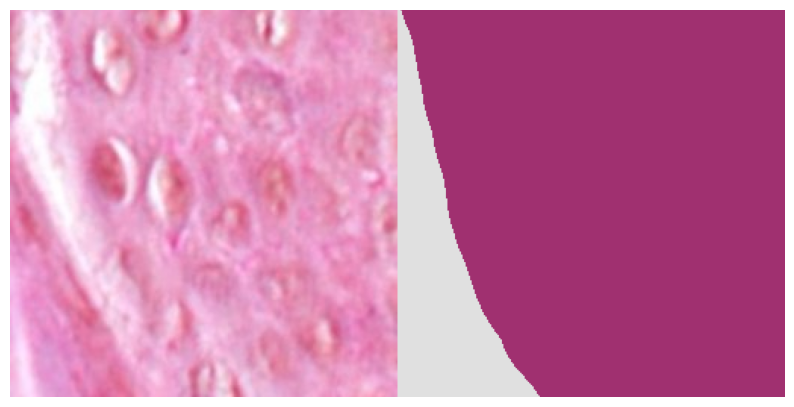

In [7]:
show_image(preprocessed_data[222])



In [8]:
from transformers import SegformerFeatureExtractor

feature_extractor = SegformerFeatureExtractor()

train_data = CustomDataset(preprocessed_data[:5000, :, :, :], feature_extractor)
val_data = CustomDataset(preprocessed_data[5000:, :, :, :], feature_extractor)


c:\Users\ammad\miniconda3\envs\tfgpu\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [9]:
id2label = {0: "A",
            1: "B",
            2: "C",
            3: "D",
            4: "E",}

label2id = {v: k for k, v in id2label.items()}

In [10]:
encoded_inputs = train_data[899]
encoded_inputs['pixel_values'].shape, encoded_inputs['labels'].shape

(torch.Size([3, 512, 512]), torch.Size([512, 512]))

In [11]:
encoded_inputs["labels"].squeeze().unique()

tensor([0, 1, 2, 4])

In [12]:
train_dataset = DataLoader(train_data, batch_size=20, shuffle=True)
val_dataset = DataLoader(val_data, batch_size=1)

In [13]:
for k, v in next(iter(train_dataset)).items():
  print(k, v.shape)

pixel_values torch.Size([20, 3, 512, 512])
labels torch.Size([20, 512, 512])


In [14]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import cached_download, hf_hub_url

model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=5,
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.3.proj.bias', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_var', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.2.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from datasets import load_metric
metric = load_metric('mean_iou')

C:\Users\ammad\AppData\Local\Temp\ipykernel_29436\1244093886.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('mean_iou')


In [16]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.00006)
model.to(device)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [18]:
scaler = torch.cuda.amp.GradScaler()

In [19]:
start_epoch = 0

In [20]:
epoch = 19 # which checkpoint_to_load
checkpoint = torch.load('checkpoint_'+str(epoch)+'_new.pth')
model.load_state_dict(checkpoint['model_state_dict'])
start_epoch = checkpoint['epoch']
loss = checkpoint['loss']


In [18]:
model.train()
for epoch in range(start_epoch, 20):
  print(f"--> Epoch: {epoch}")
  for idx, batch in enumerate(tqdm(train_dataset)):
    pixel_values = batch['pixel_values'].to(device)
    labels = batch['labels'].to(device)

    with torch.cuda.amp.autocast():
      output = model(pixel_values=pixel_values, labels=labels)
      loss, logits = output.loss, output.logits

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    with torch.no_grad():
      rescaled_logits = nn.functional.interpolate(
          logits.detach().cpu().float(),
          size=labels.shape[-2:],
          mode="bilinear",
          align_corners=False
      ) 
      predicted = rescaled_logits.argmax(1)

      # metric
      metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

    if idx % 10 == 0:
      metrics = metric._compute(predictions=predicted.detach().cpu().numpy(),
                                references=labels.detach().cpu().numpy(),
                                num_labels=len(id2label),
                                ignore_index=255)
      
      print(f"idx: {idx}", f"\t Loss: {loss.item()}","\t Mean_iou:", metrics["mean_iou"],"\t Mean accuracy:", metrics["mean_accuracy"])
  print("Saving checkpoint...")

  torch.save({
  'epoch': epoch,
  'model_state_dict': model.state_dict(),
  'loss': loss,
  }, 'checkpoint_'+str(epoch)+'.pth')

  print("Checkpoint saved!")

--> Epoch: 19


  0%|          | 0/250 [00:00<?, ?it/s]

idx: 0 	 Loss: 0.45883822441101074 	 Mean_iou: 0.4968071603320293 	 Mean accuracy: 0.5323386014361962
idx: 10 	 Loss: 0.16447503864765167 	 Mean_iou: 0.651018156347728 	 Mean accuracy: 0.7201102910010357
idx: 20 	 Loss: 0.2619684040546417 	 Mean_iou: 0.632029162513443 	 Mean accuracy: 0.7814093386344922
idx: 30 	 Loss: 0.5274686813354492 	 Mean_iou: 0.6786901120998863 	 Mean accuracy: 0.7620007890761646
idx: 40 	 Loss: 0.21402211487293243 	 Mean_iou: 0.7472538129725752 	 Mean accuracy: 0.7978618182880115
idx: 50 	 Loss: 0.38273513317108154 	 Mean_iou: 0.6166904012874654 	 Mean accuracy: 0.7209544611105938
idx: 60 	 Loss: 0.12099683284759521 	 Mean_iou: 0.6324124000896687 	 Mean accuracy: 0.6944071873458615


C:\Users\ammad\.cache\huggingface\modules\datasets_modules\metrics\mean_iou\927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


idx: 70 	 Loss: 0.3272271454334259 	 Mean_iou: 0.5824026586097003 	 Mean accuracy: 0.8046013671909411
idx: 80 	 Loss: 0.14508309960365295 	 Mean_iou: 0.614202884826414 	 Mean accuracy: 0.8479125062856246
idx: 90 	 Loss: 0.1921488642692566 	 Mean_iou: 0.7287502413071811 	 Mean accuracy: 0.7750266199834669
idx: 100 	 Loss: 0.13218194246292114 	 Mean_iou: 0.7299593129429426 	 Mean accuracy: 0.8338730706195697
idx: 110 	 Loss: 0.22116224467754364 	 Mean_iou: 0.7280272043470692 	 Mean accuracy: 0.8022869624305848


C:\Users\ammad\.cache\huggingface\modules\datasets_modules\metrics\mean_iou\927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951\mean_iou.py:258: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union


idx: 120 	 Loss: 0.1749231517314911 	 Mean_iou: 0.7778655091906383 	 Mean accuracy: 0.8436576193498637
idx: 130 	 Loss: 0.20622244477272034 	 Mean_iou: 0.7818445218996154 	 Mean accuracy: 0.886051183438948
idx: 140 	 Loss: 0.08269377052783966 	 Mean_iou: 0.6337717225554108 	 Mean accuracy: 0.7051323119855444
idx: 150 	 Loss: 0.1987145096063614 	 Mean_iou: 0.7257979955866734 	 Mean accuracy: 0.8255509480674309
idx: 160 	 Loss: 0.3144044876098633 	 Mean_iou: 0.666730693712875 	 Mean accuracy: 0.7350629471540099
idx: 170 	 Loss: 0.1640230119228363 	 Mean_iou: 0.7579027602169071 	 Mean accuracy: 0.8429401125503515
idx: 180 	 Loss: 0.19103220105171204 	 Mean_iou: 0.7650458924593091 	 Mean accuracy: 0.882557373610154
idx: 190 	 Loss: 0.14585943520069122 	 Mean_iou: 0.740949362664296 	 Mean accuracy: 0.7960739721073878
idx: 200 	 Loss: 0.24038898944854736 	 Mean_iou: 0.7483940721590822 	 Mean accuracy: 0.8155894064625849
idx: 210 	 Loss: 0.07036221027374268 	 Mean_iou: 0.8123766607621711 	 Me

In [21]:
index = 1234 #image_index
print(len(preprocessed_data))
import matplotlib.pyplot as plt
image, segmentation_mask = preprocessed_data[index][:, :256, :][:, :, [2, 1, 0]], preprocessed_data[index][:, 256:, :][:, :, [2, 1, 0]]
image.shape, segmentation_mask.shape
encodings = feature_extractor(image, return_tensors="pt")
pixel_values = encodings.pixel_values.to(device)
pixel_values.shape

6968


torch.Size([1, 3, 512, 512])

In [22]:
with torch.no_grad():
  output = model(pixel_values=pixel_values)
  rescaled_logits = nn.functional.interpolate(
      output.logits.detach().cpu().float(),
      size=segmentation_mask.shape[:2],
      mode="bilinear",
      align_corners=False
  )
  predicted = rescaled_logits.argmax(1).squeeze().detach().cpu().numpy()

print("This worked well!")


This worked well!


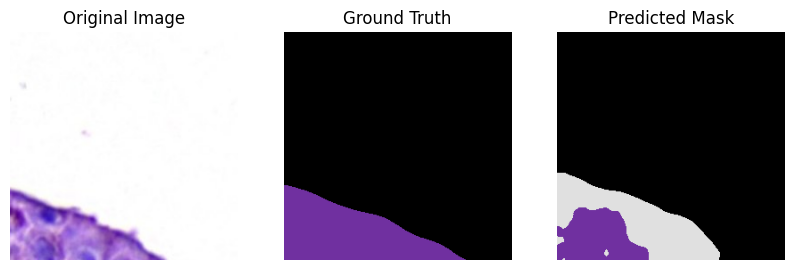

In [23]:
# show alll three images together
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.axis('off')
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(segmentation_mask)
plt.axis('off')
plt.title("Ground Truth")
plt.subplot(1, 3, 3)
plt.imshow(utilities.decoded_mask(predicted))
plt.axis('off')
plt.title("Predicted Mask")
plt.show()


testing on 20 images


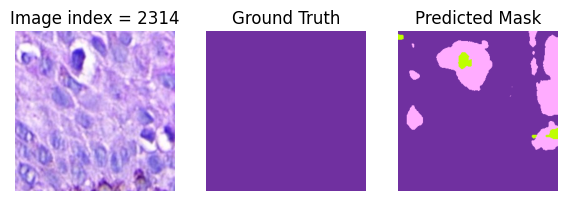

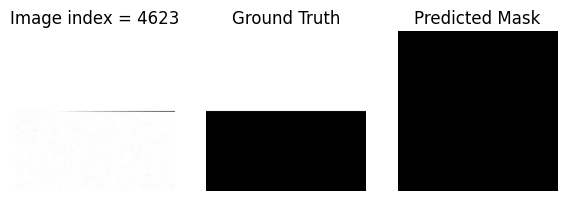

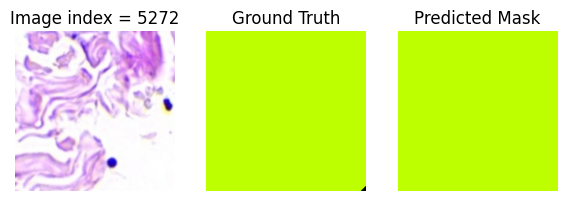

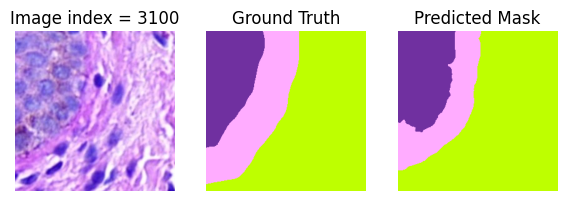

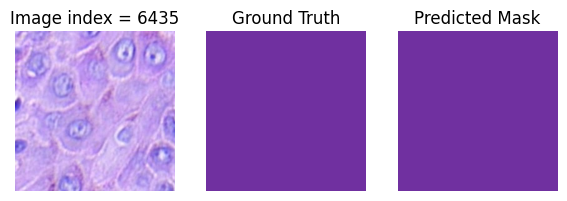

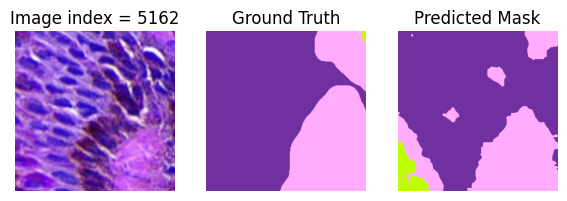

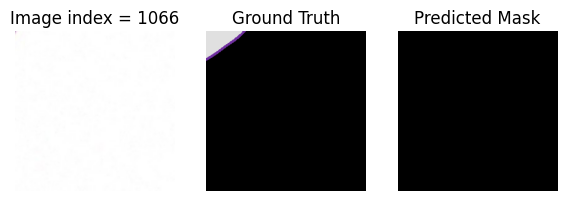

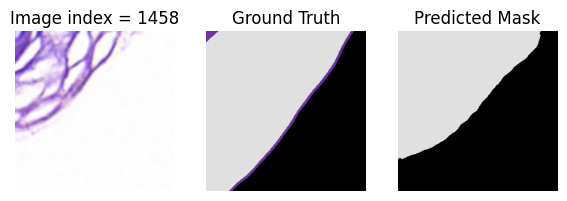

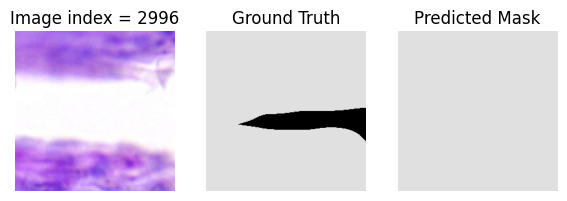

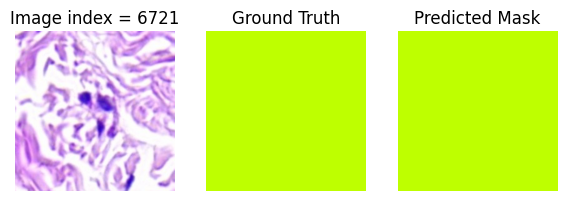

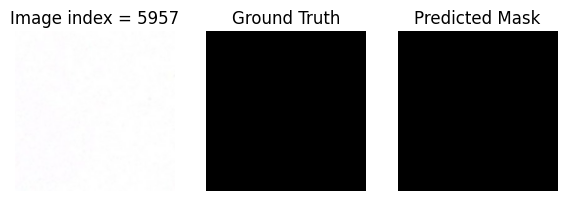

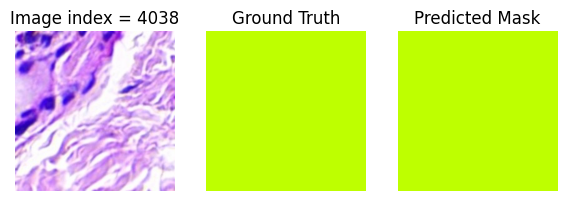

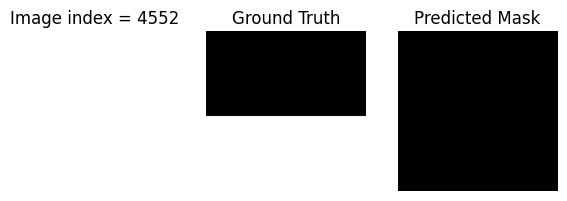

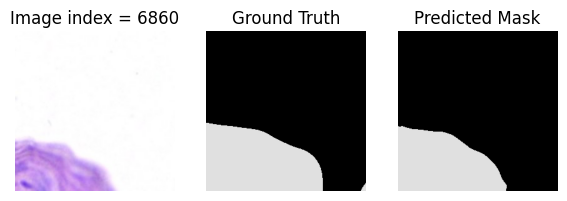

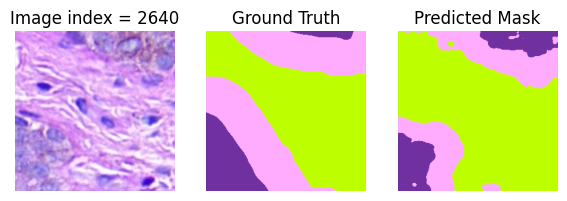

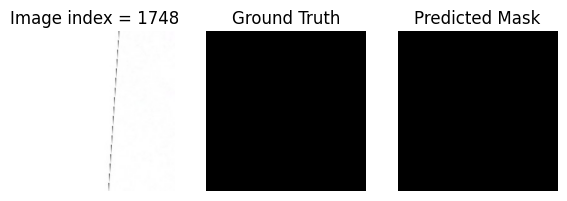

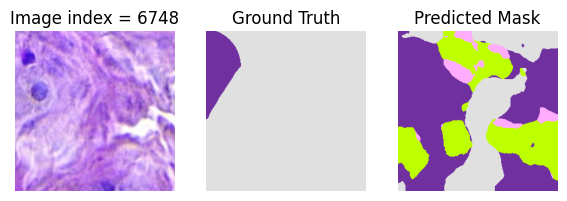

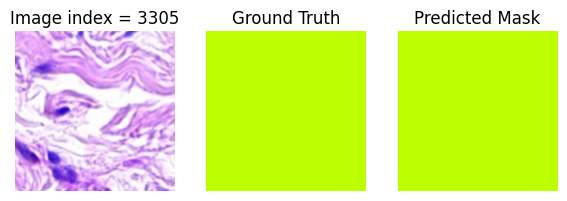

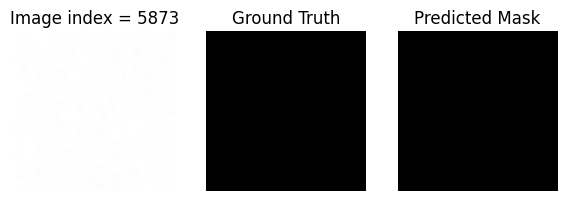

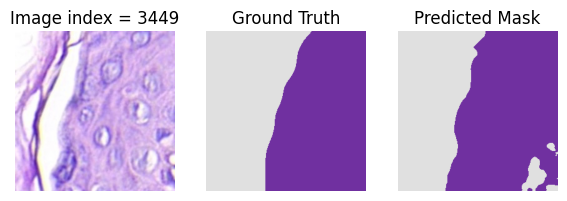

In [24]:
# randomly test n images
no_of_images = 20
import random
indexes = random.sample(range(0, len(preprocessed_data)), no_of_images)
# each value only once
indexes = list(set(indexes))
print("testing on", len(indexes), "images")
import matplotlib.pyplot as plt
for index in indexes:
    image, segmentation_mask = preprocessed_data[index][:, :256, :][:, :, [2, 1, 0]], preprocessed_data[index][:, 256:, :][:, :, [2, 1, 0]]
    image.shape, segmentation_mask.shape
    encodings = feature_extractor(image, return_tensors="pt")
    pixel_values = encodings.pixel_values.to(device)
    pixel_values.shape

    with torch.no_grad():
      output = model(pixel_values=pixel_values)
      rescaled_logits = nn.functional.interpolate(
          output.logits.detach().cpu().float(),
          size=segmentation_mask.shape[:2],
          mode="bilinear",
          align_corners=False
      )
      predicted = rescaled_logits.argmax(1).squeeze().detach().cpu().numpy()

    # show all three images together
    plt.figure(figsize=(7, 7))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Image index = " + str(index) )
    plt.subplot(1, 3, 2)
    plt.imshow(segmentation_mask)
    plt.axis('off')
    plt.title("Ground Truth")
    plt.subplot(1, 3, 3)
    plt.imshow(utilities.decoded_mask(predicted))
    plt.axis('off')
    plt.title("Predicted Mask")
    plt.show()


In [67]:
# logits = output.logits.cpu()
# logits.shape
# # Rescaling the Logits to the original size
# rescaled_logit = nn.functional.interpolate(
#     logits,
#     size=image[:, :, -1].shape,
#     mode='bilinear',
#     align_corners=False
# )
# size=image[:, :, -1].shape
# print(size )

# seg_msk = rescaled_logit.argmax(1)[0]
# color_seg = utilities_original.decoded_mask(seg_msk)

In [ ]:
#plt.imshow(color_seg)

In [ ]:
#plt.imshow(segmentation_mask)

In [ ]:
# img = image *0.5 + segmentation_mask * 0.5
# img = img.astype(np.uint8)
# plt.imshow(img)